In [1]:
# project: p11
# submitter: jmaloney3
# partner: ccmaloney
# hours: 7

In [2]:
import os
import json
import csv
from os import path

from collections import namedtuple

%matplotlib inline

In [3]:
#scatterplots
import pandas as pd

def scatter(x, y, xlabel="please label me!", ylabel="please label me!"):
    df = pd.DataFrame({"x":x, "y":y})
    ax = df.plot.scatter(x="x", y="y", color="black", fontsize=16, xlim=0, ylim=0)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.get_xaxis().get_major_formatter().set_scientific(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    

In [4]:
#p10 functions

def process_csv(filename):
    example_file = open(filename, encoding="utf-8")
    example_reader = csv.reader(example_file)
    example_data = list(example_reader)
    example_file.close()
    return example_data

sample_data_path = path.join('sample_data') # path.join('tweets', 'sample_data')
full_data_path = path.join('full_data') # path.join('tweets', 'full_data')

Tweet = namedtuple('Tweet',['tweet_id', 'username', 'num_liked', 'length'])
t = Tweet("id123", "user456", 100, 140)
t

Tweet(tweet_id='id123', username='user456', num_liked=100, length=140)

In [5]:
#p10 cont.

def fix_num(s):
    if type(s) == int:
        return s
    m = 1
    if type(s) == str:
        s = s.upper()
        if s.endswith('K'):
            m = 1000
            s = s[:-1]
        elif s.endswith('M'):
            m = 1000000
            s = s[:-1]
    try: return int(s) * m
    except ValueError: return 0
    
def process_tweets(csv_file):
    header = csv_file[0]
    csv_file = csv_file[1:]
    id_idx = header.index("tweet_id")
    user_idx = header.index("username")
    liked_idx = header.index("num_liked")
    text_idx = header.index("tweet_text")
    
    def process_tweet(row):
        if len(row) != len(header):
            return None
        return(Tweet(
            row[id_idx], 
            row[user_idx], 
            fix_num(row[liked_idx]),
            len(row[text_idx])))
        
    return list(filter(lambda x: x != None, map(process_tweet, csv_file)))

In [6]:
#p10 cont.

def process_json_tweets(data):
    def process_json_tweet(i, data):
        return(Tweet(i, data['username'],fix_num(data['num_liked']),len(data['tweet_text'])))
    return list(map(lambda x: process_json_tweet(x[0], x[1]), data.items()))
    
def read_json(file):
    f = open(file, encoding="utf-8")
    try:
        data = json.load(f)
    except:
        data = {}
    f.close()
    return data

def load_tweets(file):
    if file.endswith('.json'):
        return process_json_tweets(read_json(file))
    elif file.endswith('.csv'):
        return process_tweets(process_csv(file))
    else:
        return []

def list_dir(p):
    return list(map(lambda x: path.join(p, x), os.listdir(p)))
    
def load_dir(p):
    return list(map(lambda x: (x, load_tweets(x)), list_dir(p)))
    
def tweets_greater_than(textLength, directory):
    tweets = map(lambda x: load_tweets(x), list_dir(directory))
    tweets = [y for x in tweets for y in x if y.length > textLength]
    return tweets

def contains_tweet(i, l):
    return len(list(filter(lambda x: x.tweet_id == i, l))) != 0

def find_tweet(i, p):
    return list(map(lambda x: x[0], filter(lambda x: contains_tweet(i, x[1]), load_dir(p))))

def contains_user(u, l):
    return len(list(filter(lambda x: x.username == u, l))) != 0

def find_user(u, p):
    return list(map(lambda x: x[0], filter(lambda x: contains_user(u, x[1]), load_dir(p))))

def unique(l):
    return list(set(l))

In [7]:
def reduce(f, i, initial = None):
    if initial == None:
        try:
            rv = next(i)
        except StopIteration:
            print("Out")
            return None
    else:
        rv = initial
    
    for j in i:
        rv = f(rv, j)
    return rv

def bucketize_reduce(d, row, key, value):
    k = key(row)
    if type(k) == list:
        for i in k:
            bucketize_reduce(d, (i, value(row)), lambda x: x[0], lambda x: x[1])
    else:
        if not k in d:
            d[k] = []
        d[k].append(value(row))
    return d

def bucketize(l, key = lambda x: x[0], value = lambda x: x[1]):
    return reduce(lambda d, row: bucketize_reduce(d, row, key, value), l, initial = {})




In [8]:
#Q1: How many unique tweet lengths are present in the dataset?
all_tweets = tweets_greater_than(-1, full_data_path)
all_tweets = list(filter(lambda x: x.num_liked != None, all_tweets))


all_full_data = tweets_greater_than(-1, full_data_path)

len(unique(map(lambda x: x.length, all_full_data)))




131

In [9]:
#Q2: Which usernames appear in the dataset?
list(unique(map(lambda x: x.username, all_full_data)))

['USERID_4',
 'USERID_7',
 'USERID_5',
 'USERID_6',
 'USERID_8',
 'USERID_9',
 'USERID_2',
 'USERID_1',
 'USERID_3',
 'USERID_10']

In [10]:
 #Q3: How **prolific** is each user?
def bucketize_by_username(data):
    d = {}
    for i in data:
        if i.username not in d:
            d[i.username] = [i]
        else:
            d[i.username].append(i)
            
    return d   
#bucketize_by_username(all_full_data)

buckets_of_data = bucketize(all_full_data, key = lambda x: x.username, value = lambda x: x)
buckets_of_data

num_tweets = list(map(lambda x: len(buckets_of_data[str(x)]) ,buckets_of_data))
users = list(map(lambda x: x, buckets_of_data))
num_tweets_per_user = dict(zip(users,num_tweets))
num_tweets_per_user


{'USERID_1': 52,
 'USERID_2': 47,
 'USERID_6': 51,
 'USERID_7': 55,
 'USERID_4': 35,
 'USERID_8': 31,
 'USERID_5': 46,
 'USERID_10': 45,
 'USERID_9': 44,
 'USERID_3': 39}

In [11]:
 #Q4: What is the length of the longest tweet for each user?
def max_length(data):
    longest_tweet = max(data, key = lambda x: x.length)
    return longest_tweet

longest_tweets = list(map(lambda x: max_length(x[1]), buckets_of_data.items()))
longest_tweet_per_user = dict(map(lambda x: (x.username, x.length), longest_tweets))

longest_tweet_per_user
    

{'USERID_1': 150,
 'USERID_2': 138,
 'USERID_6': 145,
 'USERID_7': 144,
 'USERID_4': 138,
 'USERID_8': 145,
 'USERID_5': 146,
 'USERID_10': 136,
 'USERID_9': 137,
 'USERID_3': 138}

In [12]:
#Q5: What is the largest number of likes received on a tweet for each user?
def max_likes(data):
    most_liked_tweet = max(data, key = lambda x: x.num_liked)
    return most_liked_tweet
most_liked_tweets = list(map(lambda x: max_likes(x[1]), buckets_of_data.items()))
most_likes_per_user = dict(map(lambda x: (x.username, x.num_liked), most_liked_tweets))
most_likes_per_user


{'USERID_1': 9393,
 'USERID_2': 869000000,
 'USERID_6': 9149,
 'USERID_7': 9851,
 'USERID_4': 9618,
 'USERID_8': 915000,
 'USERID_5': 9608,
 'USERID_10': 9936,
 'USERID_9': 9728,
 'USERID_3': 9678}

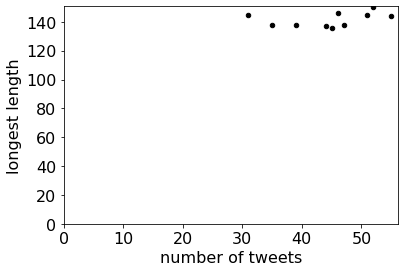

In [14]:
#Q6: What is the relationship between the number of tweets by a user and the length of their longest tweet?
scatter(num_tweets_per_user, longest_tweet_per_user, xlabel = "number of tweets", ylabel = "longest length")

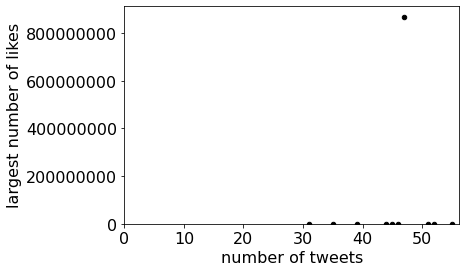

In [16]:
#Q7: What is the relationship between the number of tweets and the largest number of likes?
scatter(num_tweets_per_user, most_likes_per_user, xlabel = "number of tweets", ylabel = "largest number of likes")

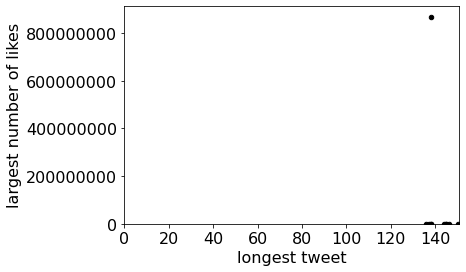

In [17]:
#Q8: What is the relationship between the length of their longest tweet and the largest number of likes?
scatter(longest_tweet_per_user, most_likes_per_user, xlabel = "longest tweet", ylabel = "largest number of likes")

In [26]:
#Q9: What is the username of the user represented by the outlier in the last two plots?
outlier_user = sorted(most_likes_per_user.items(), key = lambda x: x[1])[-1][0]
outlier_user

'USERID_2'

In [32]:
#Q10: What are the tweets made by that outlier user?
sorted(buckets_of_data[outlier_user], key = lambda x: x.num_liked, reverse = True)


[Tweet(tweet_id='1467894593', username='USERID_2', num_liked=869000000, length=136),
 Tweet(tweet_id='1467875163', username='USERID_2', num_liked=9891, length=69),
 Tweet(tweet_id='1467862806', username='USERID_2', num_liked=9465, length=68),
 Tweet(tweet_id='1467907751', username='USERID_2', num_liked=9048, length=110),
 Tweet(tweet_id='1467928764', username='USERID_2', num_liked=9026, length=41),
 Tweet(tweet_id='1467943007', username='USERID_2', num_liked=9000, length=130),
 Tweet(tweet_id='1467918682', username='USERID_2', num_liked=8884, length=102),
 Tweet(tweet_id='1467935121', username='USERID_2', num_liked=8740, length=37),
 Tweet(tweet_id='1467947913', username='USERID_2', num_liked=8578, length=36),
 Tweet(tweet_id='1467892667', username='USERID_2', num_liked=8270, length=20),
 Tweet(tweet_id='1467897316', username='USERID_2', num_liked=7890, length=64),
 Tweet(tweet_id='1467854917', username='USERID_2', num_liked=7741, length=30),
 Tweet(tweet_id='1467961106', username='USE

In [33]:
#Q11: After excluding the outlier tweet of this outlier user (found in q10), what is the average of the remaining num_liked values for this user?

In [34]:
#Q12: If we exclude the top 3 most-liked tweets (among all tweets), what is the relationship between the number of tweets and the largest number of likes?
